🔍 LA-GAS: Language Agent General Assessment Suite 란
- OpenAI에서 공개한 평가 툴킷 중 하나로, LLM 기반 에이전트의 행동을 평가하기 위해 만들어졌습니다.
- "에이전트 평가"라는 맥락에서 개발되었으며, 단순한 QA 능력 이상으로 지시 따르기, 추론, 플래닝, 툴 사용 등 복합적 행동 수행 능력을 측정할 수 있도록 설계되어 있습니다.

In [ ]:
!pip install ragas
!pip install pypdf

  Using cached langchain_community-0.3.27-py3-none-any.whl.metadata (2.9 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.7.0-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached propcache-0.3.2-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached yarl-1.20.1-cp310-cp310-win_amd64.whl.metadata (76 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0

- "질문이 좋은가?" → answer_relevancy
- "검색 문서가 적절한가?" → context_precision, context_recall
- "답이 문서 기반으로 정확한가?" → faithfulness
- "정답이랑 얼마나 같은가?" → answer_correctness

In [1]:
import os
#from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    faithfulness,
    answer_relevancy,   # 생성된 답변이 원래 질문에 얼마나 적절한지 측정. 질문에 직접적으로 응답하는 답변은 높은 점수
    context_precision,  # 생성된 답변에 사용된 컨텍스트 정보가 얼마나 관련성이 있는지 측정. 불필요한 정보 없이 질문과 관련된 컨텍스트만 포함되어 있으면 높은 점수
    context_recall,     # 답변 생성에 필요한 모든 정보가 검색된 컨텍스트에 포함되어 있는지 측정. 질문에 답하는 데 필요한 정보가 모두 검색되면 높은 점수
    answer_correctness  # 생성된 답변이 참조 답변과 비교하여 얼마나 정확한지 평가, 참조 답변이 필요
)
from ragas.evaluation import evaluate
from datasets import Dataset
import pandas as pd

c:\Users\cooju\anaconda3\envs\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

In [3]:
def load_documents(pdf_path):
    #loader = PyPDFLoader(pdf_path)  # 주어진 경로의 PDF 파일을 PyPDFLoader로 불러옴
    loader = PyMuPDFLoader(pdf_path)  # 한국어인 경우 OCR 없이도 더 잘 작동
    documents = loader.load()       # PDF 내용을 로드하여 documents 리스트로 저장
    return documents                # 로드된 documents 반환


In [4]:
def split_documents(documents):
    # 문서를 작은 텍스트 조각으로 나누기 위한 텍스트 분할기 생성
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,      # 한 조각의 최대 길이를 1000자로 설정
        chunk_overlap=200     # 조각 간에 200자의 중첩을 포함시킴
    )

    # 주어진 문서들을 분할하여 리스트로 반환
    splits = text_splitter.split_documents(documents)
    return splits  # 분할된 문서 리스트 반환


- FAISS는 Facebook이 만든 빠른 유사도 검색 라이브러리로, 대규모 벡터를 빠르게 검색할 수 있도록 인덱싱

In [5]:
def create_vectorstore(splits):
    # 텍스트 조각들을 임베딩하기 위한 OpenAI 임베딩 모델 로드
    embeddings = OpenAIEmbeddings()
    
    # FAISS 벡터스토어에 문서와 임베딩을 기반으로 인덱싱 (검색 가능한 벡터 DB 생성)
    vectorstore = FAISS.from_documents(splits, embeddings)
    
    return vectorstore  # 생성된 벡터스토어 객체 반환


In [6]:
def create_rag_pipeline(vectorstore):
    # 환경 변수에서 모델 이름을 불러와 OpenAI LLM 초기화 (온도=0: 일관된 응답 생성)
    llm = ChatOpenAI(model_name=os.getenv("OPENAI_DEFAULT_MODEL"), temperature=0)

    # FAISS 벡터스토어를 검색기(retriever)로 변환 (유사한 문서 상위 3개 검색)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

    # RAG(Retrieval-Augmented Generation) QA 체인 구성
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,                       # 사용할 언어 모델
        chain_type="stuff",           # 문서를 하나로 합쳐서 LLM에 넣는 방식
        retriever=retriever,          # 문서 검색기
        return_source_documents=True  # 응답 시 원본 문서도 함께 반환
    )

    return qa_chain  # 완성된 RAG QA 체인 반환


In [7]:
def generate_test_questions(pdf_path, num_questions=5):
    documents = load_documents(pdf_path)
    llm = ChatOpenAI(model_name=os.getenv("OPENAI_DEFAULT_MODEL"), temperature=0.9)
    questions = []
    
    for i in range(num_questions):
        prompt = f"""
다음 문서를 바탕으로 질문을 1개 생성해 주세요.
반드시 질문문장만 출력해 주세요. '질문:'이라는 표현 없이 완전한 한국어 질문 형태로만 작성해 주세요.

문서 내용:
{documents[i % len(documents)].page_content}
"""
        question = llm.invoke(prompt).content
        questions.append(question)
    
    return questions

In [8]:
def evaluate_with_ragas(qa_chain, questions):
    use_faithfulness = True
    use_answer_relevancy = True
    use_context_precision = True
    use_context_recall = True    
    use_answer_correctness = False
        
    evaluation_data = {
        "question": [],
        "answer": [],
        "contexts": []
    }
    
    if use_context_precision or use_context_recall:
        evaluation_data["reference"] = []
    
    for question in questions:
        result = qa_chain(question)
        answer = result["result"]
        contexts = [doc.page_content for doc in result["source_documents"]]
        
        evaluation_data["question"].append(question)
        evaluation_data["answer"].append(answer)
        evaluation_data["contexts"].append(contexts)
        
        if use_context_precision or use_context_recall:
            evaluation_data["reference"].append(contexts[0] if contexts else "")
    
    eval_dataset = Dataset.from_dict(evaluation_data)
    
    metrics = []
    if use_faithfulness:
        metrics.append(faithfulness)
    if use_answer_relevancy:
        metrics.append(answer_relevancy)
    if use_context_precision:
        metrics.append(context_precision)
    if use_context_recall:
        metrics.append(context_recall)
    if use_answer_correctness:
        metrics.append(answer_correctness)
    
    results = evaluate(
        eval_dataset,
        metrics=metrics
    )
    
    results_df = pd.DataFrame({
        "question": evaluation_data["question"],
        "answer": evaluation_data["answer"]
    })
    
    for metric in metrics:
        results_df[metric.name] = results[metric.name]
    
    return results_df


In [ ]:
pdf_path = "report.pdf"

documents = load_documents(pdf_path)
splits = split_documents(documents)

In [10]:
vectorstore = create_vectorstore(splits)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33628\1995968012.py:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


In [11]:
qa_chain = create_rag_pipeline(vectorstore)

In [12]:
questions = generate_test_questions(pdf_path, 20)
questions

['시가총액 상위 바이오텍의 현재 시장 상황은 어떤 영향을 받고 있으며, 향후 전망은 어떻게 예상되나요?',
 '국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떤 변화를 보였나요?',
 '2025년까지의 국내 제약/바이오 업체들의 주요 기술 이전 내역은 어떻게 변화하고 있나요?',
 '당사는 7월 15일 현재 어떤 종목을 1% 이상 보유하고 있지 않다고 밝혔는데, 이는 왜 중요한 내용인가요?',
 '현재 코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?',
 '국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떠한가요?',
 '2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 높은 총금액을 기록한 기업은 어디인가요?',
 '당사는 7월 15일 현재 상기 언급된 종목을 1% 이상 보유하고 있지 않다고 명시한 이유는 무엇인가요?',
 '코스닥 시가총액 상위 바이오텍이 강남 아파트에 비유되는 이유는 무엇인가요?',
 '국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떻게 되나요?',
 '2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 많은 기술 이전 금액을 기록한 기업은 어디인가요?',
 '당사는 7월 15일 현재 언급된 종목을 몇 퍼센트 이상 보유하고 있지 않다고 밝혔나요?',
 '코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?',
 '국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떻게 변화하고 있나요?',
 '국내 제약/바이오 업체들의 기술 이전 내역에서 2025년의 총 금액은 얼마인가요?',
 '본 조사 분석자료의 내용에 따라 투자 결정을 할 때 투자자의 책임은 어떻게 이루어지나요?',
 '현재 제약/바이오 업체의 시가총액 비중이 코스닥에서 차지하는 퍼센트는 얼마인가요?',
 '국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 변화는 어떻게 나타나고 있나요?

In [13]:
results = evaluate_with_ragas(qa_chain, questions)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_33628\2158955062.py:18: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain(question)
Evaluating: 100%|██████████| 80/80 [01:21<00:00,  1.02s/it]


In [14]:
print("평가 결과:")
print(results)

metric_columns = [col for col in results.columns if col not in ["question", "answer"]]
if metric_columns:
    avg_scores = results[metric_columns].mean()
    print("\n평균 점수:")
    print(avg_scores)


평가 결과:
                                             question  \
0   시가총액 상위 바이오텍의 현재 시장 상황은 어떤 영향을 받고 있으며, 향후 전망은 ...   
1       국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떤 변화를 보였나요?   
2   2025년까지의 국내 제약/바이오 업체들의 주요 기술 이전 내역은 어떻게 변화하고 ...   
3   당사는 7월 15일 현재 어떤 종목을 1% 이상 보유하고 있지 않다고 밝혔는데, 이...   
4   현재 코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?   
5   국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떠한가요?   
6   2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 높은 총금액을 기...   
7   당사는 7월 15일 현재 상기 언급된 종목을 1% 이상 보유하고 있지 않다고 명시한...   
8           코스닥 시가총액 상위 바이오텍이 강남 아파트에 비유되는 이유는 무엇인가요?   
9   국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떻게...   
10  2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 많은 기술 이전 ...   
11   당사는 7월 15일 현재 언급된 종목을 몇 퍼센트 이상 보유하고 있지 않다고 밝혔나요?   
12     코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?   
13     국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떻게 변화하고 있나요?   
14      국내 제약/바이오 업체들의 기술 이전 내역에서 2025년의 총 금액은 얼마인가요?   
15  본 조사 분석자료의 내용에 따라 투자 결정을 할 때 투자자의 책임은 어떻게 이루어지나요?   
16      현재 제약/바이오 업체의 시가

### 결과 시각화

In [19]:
#!pip install seaborn
!pip install koreanize-matplotlib

  Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl.metadata (992 bytes)
Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl (7.9 MB)


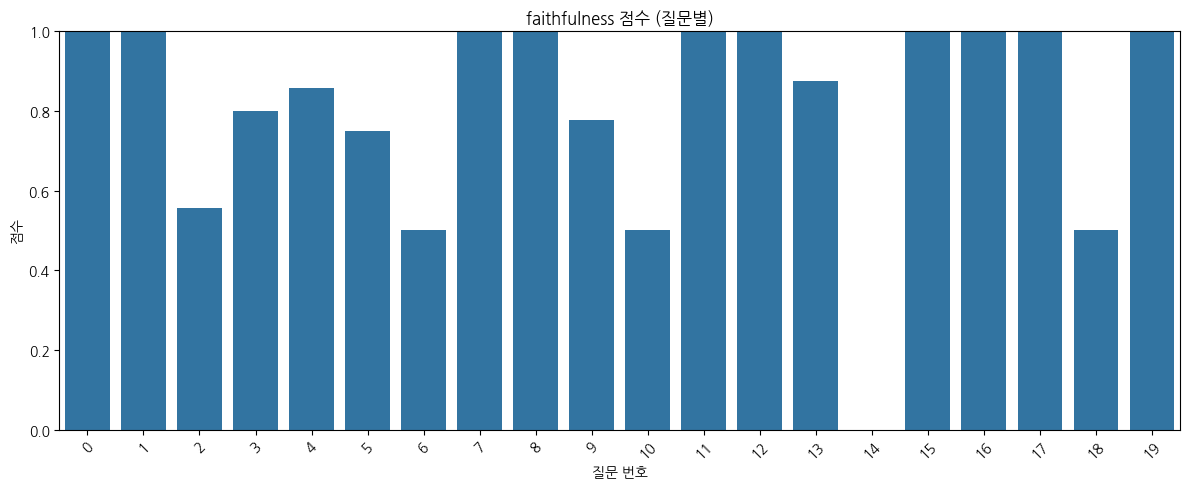

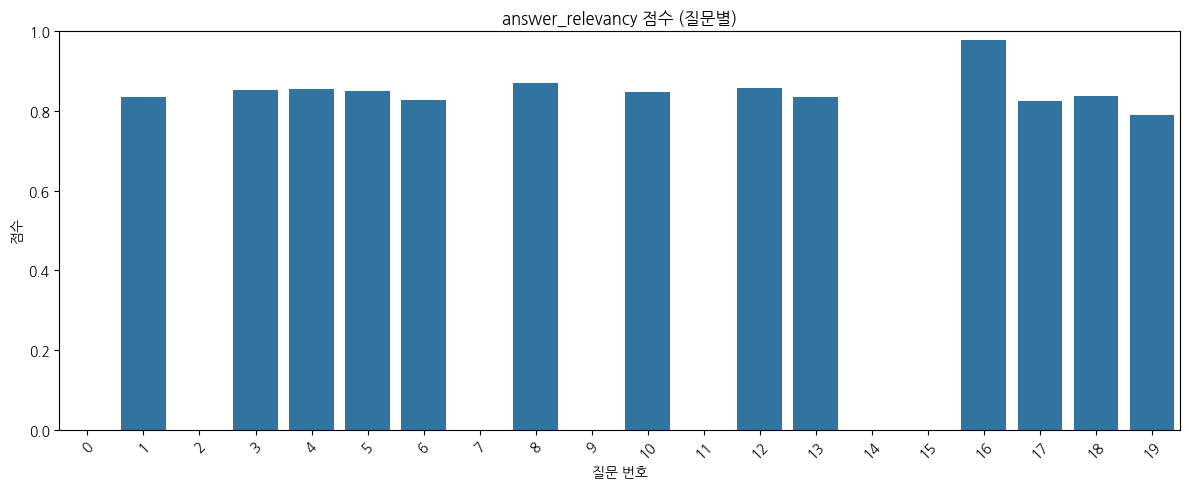

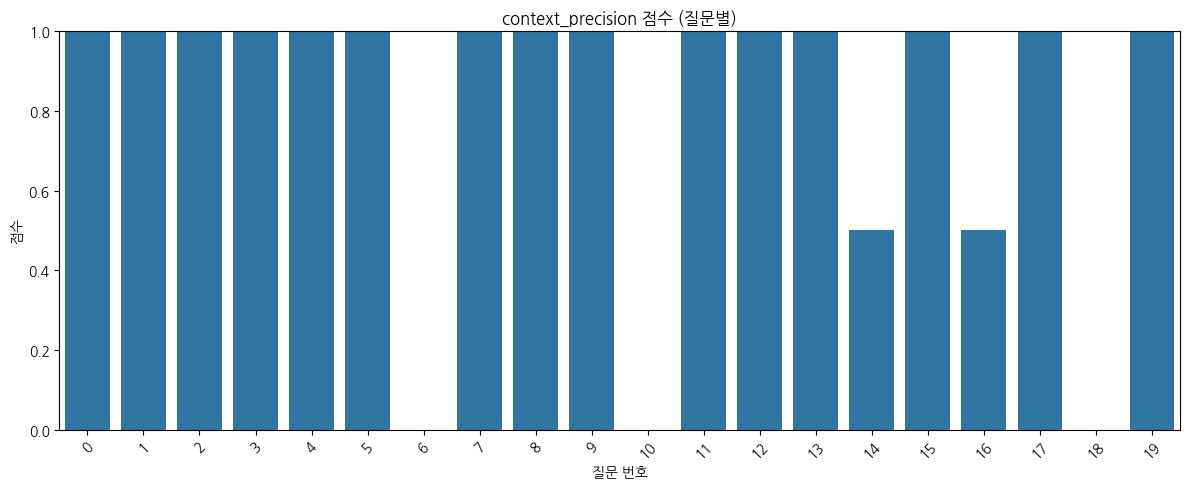

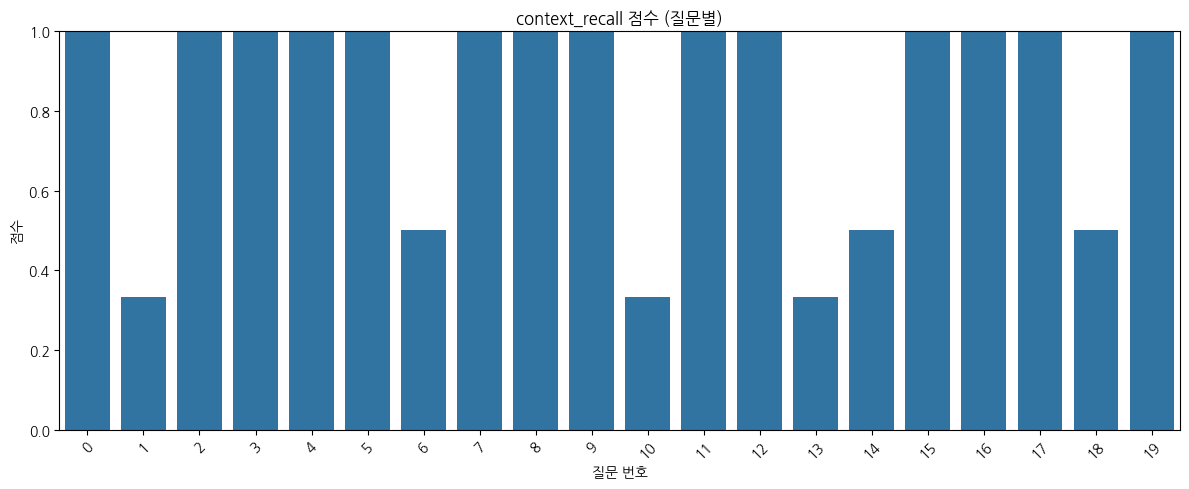

In [21]:
# 질문별 지표 점수 막대그래프
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

def visualize_ragas_results(results_df):
    metric_columns = [col for col in results_df.columns if col not in ["question", "answer"]]
    
    for metric in metric_columns:
        plt.figure(figsize=(12, 5))
        sns.barplot(x=results_df.index, y=results_df[metric])
        plt.title(f"{metric} 점수 (질문별)")
        plt.xlabel("질문 번호")
        plt.ylabel("점수")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

visualize_ragas_results(results)

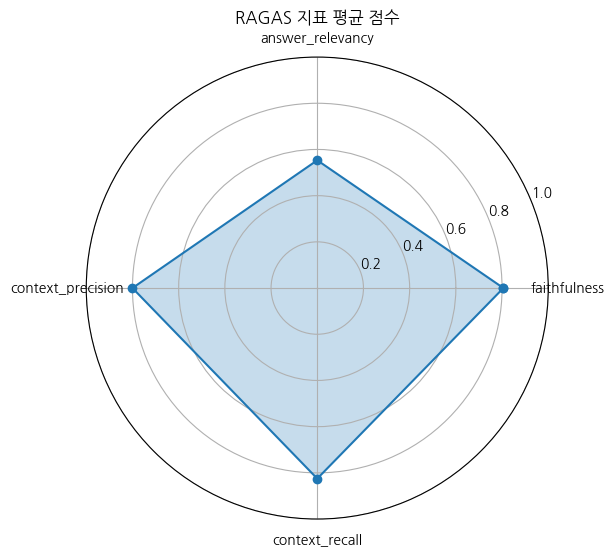

In [24]:
# 전체 평균값 레이다 차트
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(avg_scores):
    metrics = avg_scores.index.tolist()
    scores = avg_scores.values.tolist()
    
    # 각 축의 각도 설정 (점수를 먼저 안 늘림)
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    
    # 시작점으로 되돌아오기 위해 첫 점 추가 (마지막 값 = 첫 값)
    scores += scores[:1]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, scores, marker='o')
    ax.fill(angles, scores, alpha=0.25)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_title("RAGAS 지표 평균 점수")
    plt.show()

    
plot_radar_chart(avg_scores)


### Custom Metric

In [25]:
# 사용자 정의 평가 지표로 'hallucinations_metric'을 생성함
# Faithfulness 점수를 기반으로 환각 정도를 계산 (1 - faithfulness)

from dataclasses import dataclass, field  # 데이터 클래스 사용을 위한 모듈
from ragas.metrics.base import MetricWithLLM, SingleTurnMetric, MetricType  # 평가 지표의 기본 클래스들
from ragas.metrics import Faithfulness  # 기존의 Faithfulness 메트릭 사용
import typing as t  # 타입 힌트를 위한 모듈
from ragas.callbacks import Callbacks  # 평가 진행 중 이벤트 콜백
from ragas.dataset_schema import SingleTurnSample  # 단일 질문-응답 샘플 형식 정의

# 데이터 클래스 선언: 사용자 정의 평가 지표 HallucinationsMetric 정의
@dataclass
class HallucinationsMetric(MetricWithLLM, SingleTurnMetric):
    # 지표 이름 설정
    name: str = "hallucinations_metric"

    # 이 지표를 계산하기 위해 필요한 데이터 열 정의 (사용자 질문, 응답, 검색된 문맥)
    _required_columns: t.Dict[MetricType, t.Set[str]] = field(
        default_factory=lambda: {
            MetricType.SINGLE_TURN: {"user_input", "response", "retrieved_contexts"}
        }
    )

    # 클래스 초기화 이후 실행되는 후처리 함수
    def __post_init__(self):
        # 내부적으로 Faithfulness 메트릭을 초기화하여 활용함
        self.faithfulness_metric = Faithfulness(llm=self.llm)

    # 실제 점수를 계산하는 비동기 함수
    async def _single_turn_ascore(
        self, sample: SingleTurnSample, callbacks: Callbacks
    ) -> float:
        # Faithfulness 점수를 먼저 계산함
        faithfulness_score = await self.faithfulness_metric.single_turn_ascore(
            sample, callbacks
        )
        # 환각 점수 = 1 - faithfulness 점수
        return 1 - faithfulness_score


In [26]:
import os  # 환경변수에서 API 키나 모델명 등을 불러오기 위해 사용

from ragas.llms import LangchainLLMWrapper  # LangChain의 LLM을 RAGAS에서 사용 가능하도록 감싸주는 래퍼

# OpenAI의 챗 모델을 LangChain에서 불러오기
llm = ChatOpenAI(
    temperature=0,  # 일관된 결과를 위해 생성 다양성 최소화
    model_name=os.getenv("OPENAI_DEFAULT_MODEL")  # 환경변수에서 모델 이름 불러오기 (예: "gpt-4")
)

# RAGAS에서 사용할 수 있도록 LangChain LLM을 래핑
evaluator_llm = LangchainLLMWrapper(llm)

# 앞서 정의한 환각 평가 메트릭에 LLM을 연결하여 인스턴스 생성
hallucinations_metric = HallucinationsMetric(llm=evaluator_llm)

In [ ]:
# 단일 질문-응답 샘플을 생성하여 환각 점수를 계산하는 예시
sample = SingleTurnSample(
    user_input="파리는 어느 나라의 수도인가요?",
    response="파리는 프랑스의 수도입니다.",
    retrieved_contexts=["파리는 프랑스의 수도입니다. 프랑스는 유럽에 위치한 국가로, 파리는 세계적인 문화, 예술, 패션의 중심지로 알려져 있습니다."]
)
# 비동기 함수 실행 및 결과 출력
score = await hallucinations_metric.single_turn_ascore(sample)
print("Hallucination 점수:", score)

Hallucination 점수: 0.0


In [ ]:
# 단일 질문-응답 샘플을 생성하여 환각 점수를 계산하는 예시
sample = SingleTurnSample(
    user_input="파리는 어느 나라의 수도인가요?",
    response="파리는 프랑스의 수도입니다.",
    retrieved_contexts=["파리는 독일의 수도입니다. 독일은 유럽에 위치한 국가로, 파리는 세계적인 문화, 예술, 패션의 중심지로 알려져 있습니다."]
)
await hallucinations_metric.single_turn_ascore(sample)

# 비동기 함수 실행 및 결과 출력
score = await hallucinations_metric.single_turn_ascore(sample)
print("Hallucination 점수:", score)

Hallucination 점수: 1.0


In [29]:
from datasets import Dataset
import pandas as pd
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness
)

# RAG 시스템(qa_chain)으로 생성된 답변과 그에 대한 질문·문맥 정보를 기반으로 RAGAS 평가 지표들(기본 + 사용자 정의 hallucinations)을 적용해 질문별 평가 결과를 데이터프레임 형태로 반환합니다.
def evaluate_with_ragas_with_custom_metric(qa_chain, questions):
    # 사용할 평가 지표 선택 (True: 사용 / False: 미사용)
    use_faithfulness = True
    use_answer_relevancy = True
    use_context_precision = True
    use_context_recall = True    
    use_answer_correctness = False
    use_hallucinations = True  # 사용자 정의 환각 평가 추가 여부

    # 평가용 데이터 구조 초기화
    evaluation_data = {
        "question": [],   # 질문
        "answer": [],     # 생성된 답변
        "contexts": []    # 검색된 문서 조각 (복수)
    }

    # context_precision / recall을 위한 reference 컬럼 추가
    if use_context_precision or use_context_recall:
        evaluation_data["reference"] = []

    # 각 질문에 대해 RAG QA 체인 실행
    for question in questions:
        result = qa_chain(question)  # RAG 시스템에서 답변 생성
        answer = result["result"]
        contexts = [doc.page_content for doc in result["source_documents"]]

        # 평가용 데이터 누적
        evaluation_data["question"].append(question)
        evaluation_data["answer"].append(answer)
        evaluation_data["contexts"].append(contexts)

        # reference 문서 (보통 첫 번째 context) 추가
        if use_context_precision or use_context_recall:
            evaluation_data["reference"].append(contexts[0] if contexts else "")

    # 평가를 위한 huggingface Dataset 객체 생성
    eval_dataset = Dataset.from_dict(evaluation_data)

    # 사용할 메트릭 리스트 구성
    metrics = []
    if use_faithfulness:
        metrics.append(faithfulness)
    if use_answer_relevancy:
        metrics.append(answer_relevancy)
    if use_context_precision:
        metrics.append(context_precision)
    if use_context_recall:
        metrics.append(context_recall)
    if use_answer_correctness:
        metrics.append(answer_correctness)
    if use_hallucinations:
        # 사용자 정의 환각 평가 메트릭 추가
        hallucinations_metric = HallucinationsMetric(llm=evaluator_llm)
        metrics.append(hallucinations_metric)

    # RAGAS 평가 실행
    results = evaluate(
        eval_dataset,
        metrics=metrics
    )

    # 결과를 DataFrame 형태로 정리
    results_df = pd.DataFrame({
        "question": evaluation_data["question"],
        "answer": evaluation_data["answer"]
    })

    # 각 메트릭 결과 컬럼에 추가
    for metric in metrics:
        results_df[metric.name] = results[metric.name]

    return results_df  # 평가 결과 데이터프레임 반환


In [30]:
results = evaluate_with_ragas_with_custom_metric(qa_chain, questions)

Evaluating: 100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


In [33]:
print("평가 결과:")
print(results)

metric_columns = [col for col in results.columns if col not in ["question", "answer"]]
if metric_columns:
    avg_scores = results[metric_columns].mean()
    print("\n평균 점수:")
    print(avg_scores)


평가 결과:
                                             question  \
0   시가총액 상위 바이오텍의 현재 시장 상황은 어떤 영향을 받고 있으며, 향후 전망은 ...   
1       국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떤 변화를 보였나요?   
2   2025년까지의 국내 제약/바이오 업체들의 주요 기술 이전 내역은 어떻게 변화하고 ...   
3   당사는 7월 15일 현재 어떤 종목을 1% 이상 보유하고 있지 않다고 밝혔는데, 이...   
4   현재 코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?   
5   국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떠한가요?   
6   2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 높은 총금액을 기...   
7   당사는 7월 15일 현재 상기 언급된 종목을 1% 이상 보유하고 있지 않다고 명시한...   
8           코스닥 시가총액 상위 바이오텍이 강남 아파트에 비유되는 이유는 무엇인가요?   
9   국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이에 대한 최근 동향은 어떻게...   
10  2025년까지 국내 제약/바이오 업체들의 기술 이전 내역에서 가장 많은 기술 이전 ...   
11   당사는 7월 15일 현재 언급된 종목을 몇 퍼센트 이상 보유하고 있지 않다고 밝혔나요?   
12     코스닥 시가총액 상위 바이오텍의 주가 상승에 영향을 미치는 주요 요인은 무엇인가요?   
13     국내 제약/바이오 업체들의 기술 이전 건 수와 금액 추이는 어떻게 변화하고 있나요?   
14      국내 제약/바이오 업체들의 기술 이전 내역에서 2025년의 총 금액은 얼마인가요?   
15  본 조사 분석자료의 내용에 따라 투자 결정을 할 때 투자자의 책임은 어떻게 이루어지나요?   
16      현재 제약/바이오 업체의 시가